# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções de Custo](#Funções-de-custo)

[Implementação](#Implementação)

[Testes](#Testes)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Espiral](#Espiral)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_circles
from utils.samples_generator import make_spiral
from utils import plots

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def softmax(x, derivative=False):
    exp = np.exp(x)
    exp_sum = np.sum(exp, axis=1, keepdims=True)
    if derivative: 
        return 1.0
    return exp/exp_sum

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções de Custo

In [3]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def softmax_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)/y.shape[0]
    y_arg = np.argmax(y, axis=1)
    return np.mean(-np.log(y_pred[range(y_pred.shape[0]), y_arg]))

# Implementação 

__TODO__:
- regularização
- evitar overflow das funções de ativação
- métodos de inicialização de pesos e bias
- mini-batch SGD

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

In [4]:
class NeuralNetwork():
    def __init__(self, layers_size, activations, cost_func, learning_rate=1e-3):
        self.layers_size = layers_size
        self.activations = activations
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self._activ_inp = []
        self._activ_out = []
        self.weights = [np.random.randn(out, inp) for inp, out in zip(self.layers_size[:-1], self.layers_size[1:])]
        self.biases = [np.random.randn(1, out) for out in self.layers_size[1:]]
            
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                cost = self.cost_func(y, y_pred)
                print("epoch: {0:=4}/{1} cost: {2:.8f}".format(epoch, epochs, cost))
    
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self._activ_inp, self._activ_out = [], []
        self._activ_out.append(x)
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            y = np.dot(self._activ_out[-1], w.T) + b
            self._activ_inp.append(y)
            self._activ_out.append(activation(y))
        return self._activ_out[-1]
    
    def __backprop(self, y, y_pred):
        self._activ_out.pop()
        
        last_delta = self.cost_func(y, y_pred, derivative=True)
        dweights, dbiases = [], []
        for inp, out, w, activation in zip(self._activ_inp[::-1], self._activ_out[::-1], self.weights[::-1], self.activations[::-1]):
            dactivation = activation(inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, w)
            dweights.append(np.dot(dactivation.T, out))
            dbiases.append(1.0*dactivation.sum(axis=0, keepdims=True))
        
        self.weights = [w - self.learning_rate*dw for w, dw in zip(self.weights, reversed(dweights))]
        self.biases  = [b - self.learning_rate*db for b, db in zip(self.biases, reversed(dbiases))]

# Testes

## Exemplo 1

In [5]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 2, 2], activations=[sigmoid, sigmoid], cost_func=mse, learning_rate=0.5)

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.weights = [w1, w2]
nn.biases = [b1, b2]

nn.fit(x, y, epochs=1, verbose=1)
for w in nn.weights:
    print(w)

epoch:    0/1 cost: 0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


## Classificação Binária

### Porta AND/OR

In [6]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 0.42042668
epoch: 1000/5000 cost: 0.04529692
epoch: 2000/5000 cost: 0.03092276
epoch: 3000/5000 cost: 0.02483263
epoch: 4000/5000 cost: 0.02128885
[array([[ 7.28451388,  7.28451388]])] [array([[-11.01429318]])]
[[  1.64644073e-05]
 [  2.34357182e-02]
 [  2.34357182e-02]
 [  9.72205650e-01]]


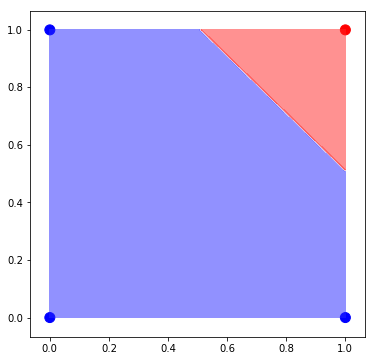

In [7]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.weights, nn.biases)
print(nn.predict(x))

plots.plot_nn_classifier_3d_in_2d(x, y, nn, threshold=0.5)

### Porta XOR

In [8]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 0.70000338
epoch: 1000/5000 cost: 0.04955136
epoch: 2000/5000 cost: 0.03003868
epoch: 3000/5000 cost: 0.02325103
epoch: 4000/5000 cost: 0.01957112
[[ 0.01553237]
 [ 0.98370554]
 [ 0.98370784]
 [ 0.0200485 ]]


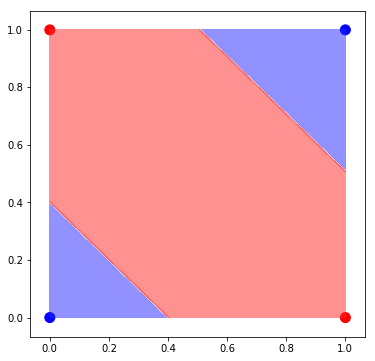

In [9]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 1], activations=[sigmoid, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

plots.plot_nn_classifier_3d_in_2d(x, y, nn, threshold=0.5)

### 2 Clusters

(100, 2) (100, 1)


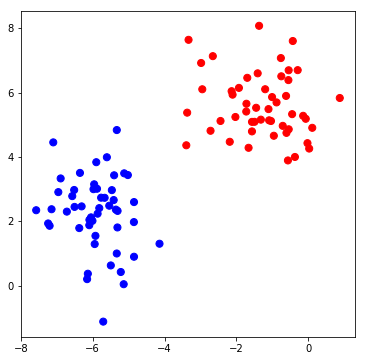

In [22]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], c=y, s=50, cmap='bwr')

epoch:    0/5000 cost: 0.87053345
epoch: 1000/5000 cost: 0.03482333
epoch: 2000/5000 cost: 0.02386907
epoch: 3000/5000 cost: 0.01905797
epoch: 4000/5000 cost: 0.01620544


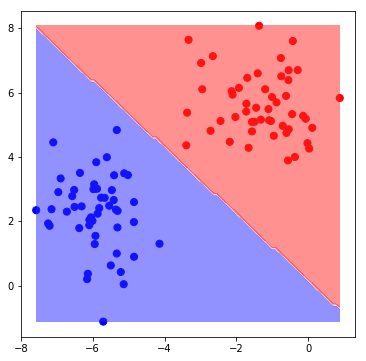

In [23]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_nn_classifier_3d_in_2d(x, y, nn, threshold=0.5, s=50)

### 4 Clusters

(500, 2) (500, 1)


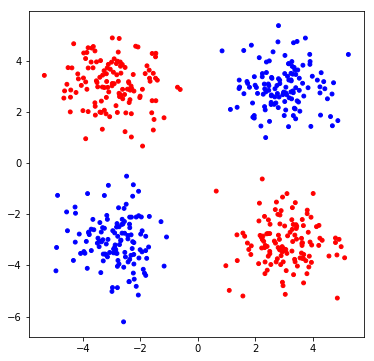

In [12]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], c=y, s=15, cmap='bwr')

epoch:    0/5000 cost: 0.96633740
epoch: 1000/5000 cost: 0.02971818
epoch: 2000/5000 cost: 0.01885412
epoch: 3000/5000 cost: 0.01439925
epoch: 4000/5000 cost: 0.01192069


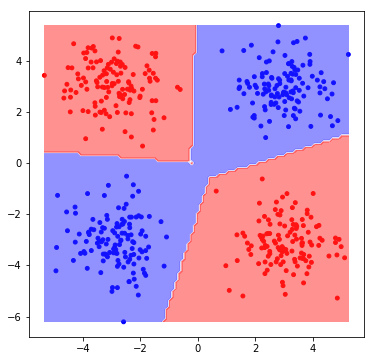

In [13]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 3, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_nn_classifier_3d_in_2d(x, y, nn, threshold=0.5, s=15)

### Círculos

(500, 2) (500, 1)


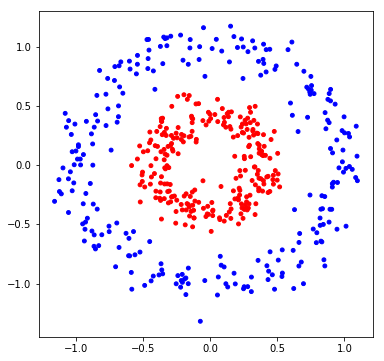

In [24]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], c=y, s=15, cmap='bwr')

epoch:    0/10000 cost: 0.71396691
epoch: 1000/10000 cost: 0.01416363
epoch: 2000/10000 cost: 0.00848724
epoch: 3000/10000 cost: 0.00641056
epoch: 4000/10000 cost: 0.00530683
epoch: 5000/10000 cost: 0.00460733
epoch: 6000/10000 cost: 0.00411807
epoch: 7000/10000 cost: 0.00375448
epoch: 8000/10000 cost: 0.00346997
epoch: 9000/10000 cost: 0.00324016


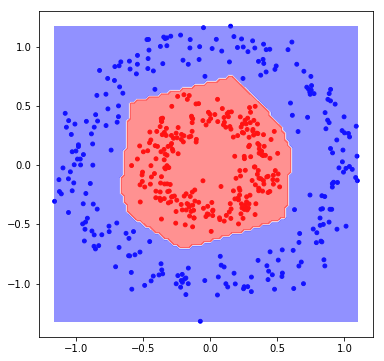

In [25]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 3, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-2)

nn.fit(x, y, epochs=10000, verbose=1000)

plots.plot_nn_classifier_3d_in_2d(x, y, nn, threshold=0.5, s=15)

### Espiral

(200, 2) (200, 1)


(-5.5063624278387513,
 5.5063624278387513,
 -4.7458706302762419,
 4.7458706302762419)

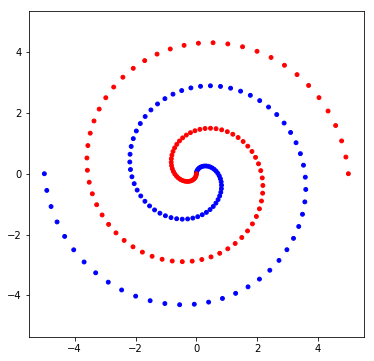

In [16]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], c=y, s=15, cmap='bwr')
plt.axis('equal')

epoch:    0/100000 cost: 0.83156171
epoch: 10000/100000 cost: 0.14180807
epoch: 20000/100000 cost: 0.13589120
epoch: 30000/100000 cost: 0.13507085
epoch: 40000/100000 cost: 0.98791131
epoch: 50000/100000 cost: 0.01403612
epoch: 60000/100000 cost: 0.01163260
epoch: 70000/100000 cost: 0.01038827
epoch: 80000/100000 cost: 0.00951929
epoch: 90000/100000 cost: 0.00901813


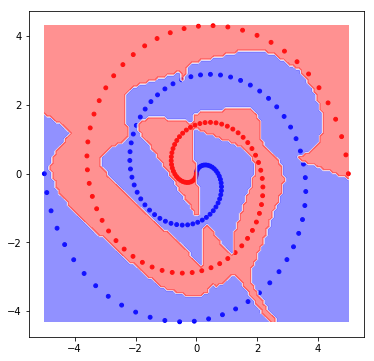

In [17]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 6, 6, 6, 1], activations=[tanh, tanh, tanh, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-2)

nn.fit(x, y, epochs=100000, verbose=10000)

plots.plot_nn_classifier_3d_in_2d(x, y, nn, threshold=0.5, s=15)

## Classificação Multiclasse

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


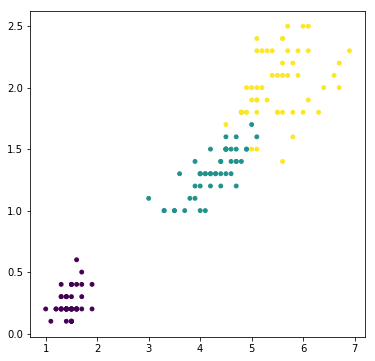

In [26]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

plt.figure(figsize=(6,6))
plt.scatter(x[:,0], x[:,1], c=y, s=15)

In [19]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


In [27]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1, 3], activations=[tanh, softmax], cost_func=softmax_cross_entropy, learning_rate=1e-2)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

epoch:    0/10000 cost: 1.20588948
epoch: 1000/10000 cost: 0.58000120
epoch: 2000/10000 cost: 0.50900427
epoch: 3000/10000 cost: 0.48188572
epoch: 4000/10000 cost: 0.45430727
epoch: 5000/10000 cost: 0.41400288
epoch: 6000/10000 cost: 0.36912208
epoch: 7000/10000 cost: 0.33200716
epoch: 8000/10000 cost: 0.30417598
epoch: 9000/10000 cost: 0.28286868


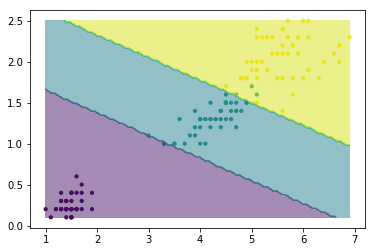

In [28]:
x1, x2 = np.meshgrid(np.linspace(x[:,0].min(), x[:,0].max(), 100), np.linspace(x[:,1].min(), x[:,1].max(), 100))
x_mesh = np.array([x1.ravel(), x2.ravel()]).T
y_mesh = np.argmax(softmax(nn.predict(x_mesh)), axis=1)

plt.figure(0)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=10)
plt.contourf(x1, x2, y_mesh.reshape(x1.shape), alpha=0.5)

# Referências

[Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)